## Mixture of Gaussians with pyMC3

In [1]:
import theano
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

## Generate Toy data with K components.

In [2]:
np.random.seed(42)
# Specify number of groups
K = 3
# Means 
mus = [ 0, 6,-8]
#Standard deviations,
sigmas = [ 1, .5, 3]
#Proportions
ps = [.2, .5,.3]
# Total amount of data
N = 200
# Stack data into a single array
one = np.random.normal(mus[0], sigmas[0], int(ps[0]*N))
two = np.random.normal(mus[1], sigmas[1], int(ps[1]*N))
three = np.random.normal(mus[2], sigmas[2], int(ps[2]*N))
X = np.r_[one,two,three]
X.shape

(200,)

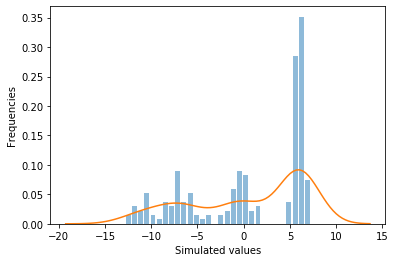

In [3]:
import seaborn as sns

## Plot the data as a histogram
plt.hist(X, bins=30, alpha=0.5, density=True, rwidth=0.8)

# Add axes labels
plt.xlabel('Simulated values')
plt.ylabel('Frequencies')
_=sns.kdeplot(X)

### Init cluster centers

In [4]:
m_0 = np.random.normal(0,5,size=K)  # Randomly or use init from KMeans++

## Build model

In [5]:
with pm.Model() as gmm:
    
    # Prior over pi
    pi = pm.Dirichlet('pi', a=np.ones(K))
    
    # Prior over z
    # z is the component that the data point is being sampled from.
    # Since we have N data points, z should be a vector with N elements.
    z = pm.Categorical('z', p=pi, shape=N)
    
    # Prior over the component means and standard deviations
    mu = pm.Normal('mu', mu=0., sd=10., shape=K, testval = m_0)
    
    sigma = pm.Gamma('sigma', alpha=2, beta=1, shape=K)
    
    # Specify the likelihood
    Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=X)

Without a value passed to
step, PyMC3 will try to automatically assign an appropriate algorithm depending on the
type of variable, with No U-Turn Sampling (NUTS; Hoffman & Gelman, 2014) used for
continuous variables and Gibbs sampling used for discrete variables (CategoricalGibbsMetropolis
in PyMC3).

### Explicit Sampling definition

In [6]:
with gmm:
    continous = pm.NUTS(vars=[pi,sigma,mu])    
    discrete = pm.CategoricalGibbsMetropolis(vars=[z])
    # Start the sampler!
    trace = pm.sample(draws=2500, step=[continous, discrete], random_seed=42)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma, pi]
>CategoricalGibbsMetropolis: [z]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [01:50<00:00, 54.17draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [7]:
pm.summary(trace,varnames=['mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],-8.009,0.377,-8.682,-7.261,0.008,0.005,2445.0,2445.0,2529.0,2232.0,1.0
mu[1],-0.273,0.176,-0.611,0.050,0.003,0.002,3567.0,3237.0,3575.0,3797.0,1.0
mu[2],5.985,0.049,5.895,6.079,0.001,0.000,5292.0,5285.0,5344.0,3062.0,1.0


In [8]:
pmus = trace['mu'].mean(0)
pps = trace['pi'].mean(0)
psigmas = trace['sigma'].mean(0)
pmus,pps,psigmas

(array([-8.0091891 , -0.27325856,  5.9851003 ]),
 array([0.29232457, 0.21048004, 0.49719539]),
 array([2.49602363, 1.03748153, 0.47670064]))

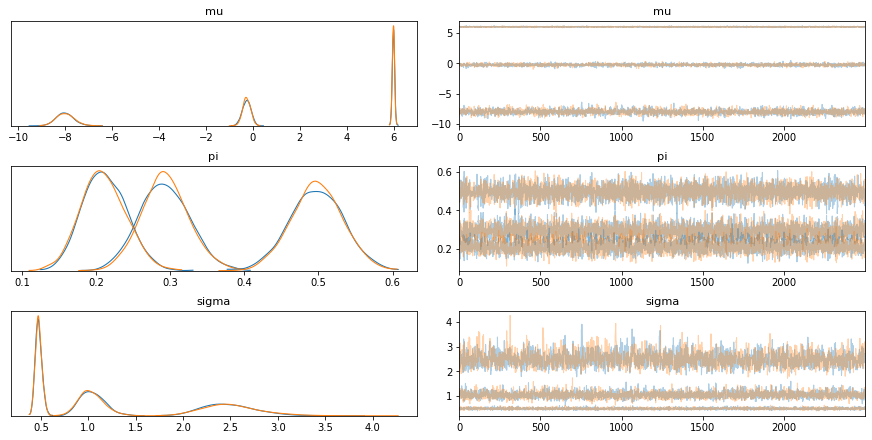

In [9]:
_=pm.traceplot(trace, varnames=['mu','pi','sigma']) # Specify which variables to plot
             
#lines={'mu':pmus,'pi':pps,'sigma':psigmas}) # Plots straight lines - useful

In [10]:
pm.stats.summary(trace,varnames=['mu','pi','sigma'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu[0],-8.009,0.377,-8.682,-7.261,0.008,0.005,2445.0,2445.0,2529.0,2232.0,1.00
mu[1],-0.273,0.176,-0.611,0.050,0.003,0.002,3567.0,3237.0,3575.0,3797.0,1.00
mu[2],5.985,0.049,5.895,6.079,0.001,0.000,5292.0,5285.0,5344.0,3062.0,1.00
pi[0],0.292,0.033,0.230,0.354,0.000,0.000,5150.0,5113.0,5144.0,3868.0,1.00
pi[1],0.210,0.030,0.156,0.266,0.000,0.000,3933.0,3928.0,3926.0,3888.0,1.00
pi[2],0.497,0.035,0.427,0.560,0.000,0.000,5873.0,5870.0,5873.0,3941.0,1.00
sigma[0],2.496,0.292,2.004,3.069,0.008,0.006,1414.0,1361.0,1532.0,1745.0,1.01
sigma[1],1.037,0.132,0.802,1.284,0.002,0.002,3014.0,2988.0,3039.0,2888.0,1.00
sigma[2],0.477,0.035,0.411,0.540,0.000,0.000,5359.0,5274.0,5466.0,4016.0,1.00


In [11]:
pm.gelman_rubin(trace,varnames=['mu','sigma','pi'])

<xarray.Dataset>
Dimensions:      (mu_dim_0: 3, pi_dim_0: 3, sigma_dim_0: 3)
Coordinates:
  * sigma_dim_0  (sigma_dim_0) int64 0 1 2
  * pi_dim_0     (pi_dim_0) int64 0 1 2
  * mu_dim_0     (mu_dim_0) int64 0 1 2
Data variables:
    mu           (mu_dim_0) float64 1.002 1.002 1.002
    sigma        (sigma_dim_0) float64 1.006 1.003 1.001
    pi           (pi_dim_0) float64 1.003 1.001 1.002

## Label switching problem

The ordering of the
component parameters being sampled in the first chain is not the same ordering of component
parameters in any of the other chains, leading to warnings of divergent chains.

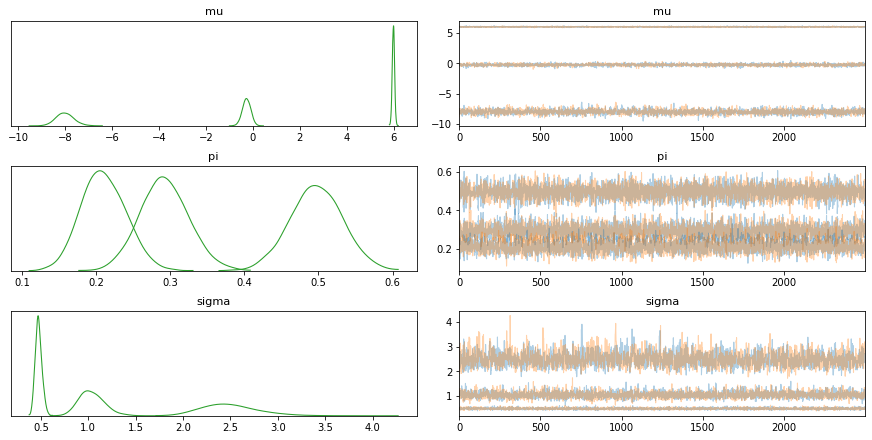

In [12]:
_=pm.traceplot(trace,varnames=['mu','pi','sigma'], combined=True)

One way to address this issue is by explicitly
providing the same starting value across chains for a component variable using the testval
argument so that the each chain is likely to have the same mean value assigned to each
component.

In [13]:
with pm.Model() as rgmm:
    
    p = pm.Dirichlet('p', a=np.ones(K))
    z = pm.Categorical('z', p=p, shape=N)
    mu = pm.Normal('mu', mu=0., sd=10., shape=K, testval = [-5, 0, 5])
    
    sigma = pm.HalfCauchy('sigma', beta=1., shape=K)

    Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=X)
    continous = pm.NUTS(vars=[p,sigma,mu])
    discrete = pm.CategoricalGibbsMetropolis(vars=[z])
    trace = pm.sample(draws=2000, nchains=2, step=[continous, discrete], random_seed=42)

ValueError: Unused step method arguments: {'nchains'}

In [ ]:
_=pm.traceplot(trace,varnames=['mu','p','sigma'], combined=True)

## Model Comparison using WAIC

In [ ]:
## Build list of models
# We want a range of models ranging from K=2 to K=4
K_range = np.arange(2,5)
# Initialize lists
gmm_list = []
trace_list = []
# Specify some sampling options
draws = 500
nchains = 4

In [ ]:
for K in K_range:
    model =  pm.Model(name = f'{K}-Group')
    gmm_list += [model]
    with model:
        
        # Prior over the component means and standard deviations
        mu = pm.Normal('mu', mu=0., sd=10., shape=K, testval = K*np.linspace(-5,5,K))
        sigma = pm.HalfCauchy('sigma', beta=1., shape=K)
        
        if K > 1:
            p = pm.Dirichlet('p', a=np.ones(K))
            z = pm.Categorical('z', p=p, shape=N)
            
            Y_obs = pm.Normal('Y_obs', mu=mu[z], sd=sigma[z], observed=X)
            # Specify the sampling algorithms to use
            cont = pm.NUTS(vars=[p, mu, sigma])
            dicr = pm.CategoricalGibbsMetropolis(vars=[z])
            steps = [cont,dicr]
        
        else:
            Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=X)
            step1 = pm.NUTS(vars=[mu, sigma])
            steps = [step1]
            
        trace_list += [pm.sample(draws=draws, nchains=nchains, tune=500, 
                                 step=steps, random_seed=42)]

In [ ]:
# Convert model and trace into dictionary pairs
dict_pairs = dict(zip(gmm_list,trace_list))
compare = pm.compare(dict_pairs, ic='LOO')

In [ ]:
pm.compare?

In [ ]:
compare

In [ ]:
gm = gmm_list[2]
tr = trace_list[2]

gm.basic_RVs

In [ ]:
pm.summary(tr,varnames=['4-Group_mu'])

In [ ]:
pp = pm.sample_ppc(model=gm, trace=tr)
plt.figure(figsize=(14,8))
# Plot original data
plt.hist(X, bins=20, alpha=0.5, density=True, label='Data', rwidth=0.9)
# Plot posterior predictives on top of that
plt.hist(np.random.choice(pp['4-Group_Y_obs'].flatten(),size=len(X)), bins=20, rwidth=0.9, alpha=0.5, density=True,label='Predictions')
# Add legend and axes labels
plt.legend()
plt.xlabel('Simulated values')
plt.ylabel('')